In [1]:
# import and install packages

!pip3 install -q torch
!pip3 install -q torchvision
!pip3 install -q tqdm
!pip install -q google-colab

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from google.colab import files
from google.colab import drive
import json
from PIL import Image, ImageDraw
from IPython.core.ultratb import AutoFormattedTB
from PIL import Image
import glob
__ITB__ = AutoFormattedTB(mode = 'Plain',color_scheme='LightBg', tb_offset = 1)


# assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


Load Images

In [2]:
drive.mount('/content/drive')
path_coco = "/content/damage_coco"
path_robo = "/content/damage_robo"

if not os.path.exists(path_coco):
    os.makedirs(path_coco)
if not os.path.exists(path_robo):
    os.makedirs(path_robo)

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/College/3.\ Junior/Winter\ Semester/CS\ 474/Final\ DL/Car_Data/damage_coco.zip -d /content/damage_coco
!unzip -q /content/drive/MyDrive/College/3.\ Junior/Winter\ Semester/CS\ 474/Final\ DL/Car_Data/damage_roboflow.zip -d /content/damage_robo
# !unzip  -q /content/drive/MyDrive/DL_Project/damage_coco.zip -d /content/damage_coco
# !unzip -q /content/drive/MyDrive/DL_Project/damage_roboflow.zip -d /content/damage_robo

In [4]:
def resize(root_folder):
  for subdir, dirs, files in os.walk(root_folder):
      for file in files:
          # get the file extension and check if it's an image
          ext = os.path.splitext(file)[-1].lower()
          
          if ext in ['.jpg', '.jpeg', '.png', '.bmp']:
              # get the full path of the image file
              file_path = os.path.join(subdir, file)
              
              # open the image and resize it to a smaller size
              img = Image.open(file_path)
              os.remove(file_path)
              img = img.resize((256, 256), resample=Image.LANCZOS)
              
              # save the compressed image in the same folder with a new name
              new_file_name = os.path.splitext(file)[0] + ext
              img.save(os.path.join(subdir, new_file_name), quality=70)


In [5]:
# resize damage_coco training images
resize("/content/damage_coco/train")

# resize damage_coco test images
resize("/content/damage_coco/val")

# resize damage_robo training images
resize("/content/damage_robo/train")


In [6]:
# !rmdir /content/damage_coco/val/.ipynb_checkpoints/

In [7]:
# make a new file path for the training images for the data loader
path_coco_train = "/content/damage_coco/train/0"
path_coco_test = "/content/damage_coco/test/0"

if not os.path.exists(path_coco_train):
    os.makedirs(path_coco_train)
if not os.path.exists(path_coco_test):
    os.makedirs(path_coco_test)


path_robo_train = "/content/damage_robo/train/0"
path_robo_test = "/content/damage_robo/test/0"

if not os.path.exists(path_robo_train):
    os.makedirs(path_robo_train)
if not os.path.exists(path_robo_test):
    os.makedirs(path_robo_test)

# move images:

In [8]:
!rm /content/damage_coco/test/*.jpg

!mv /content/damage_coco/train/*.jpg /content/damage_coco/train/0
!mv /content/damage_coco/val/*.jpg /content/damage_coco/test/0
!mv /content/damage_coco/val/*.json /content/damage_coco/test

!mv /content/damage_robo/train/test_set_*.jpg /content/damage_robo/test/0
!mv /content/damage_robo/train/*.jpg /content/damage_robo/train/0

!rm /content/damage_coco/img/*.jpg
!rmdir /content/damage_coco/img
!rmdir /content/damage_coco/val

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# STANFORD TRAINING ANNOTATION COCO DATA
ratio = 4
size = 256
width, height = size, size

# make a new file path for the training masks for the data loader
coco_mask_train = "/content/damage_coco/masks_train/0"
coco_mask_test = "/content/damage_coco/masks_test/0"
if not os.path.exists(coco_mask_train):
    os.makedirs(coco_mask_train)
if not os.path.exists(coco_mask_test):
    os.makedirs(coco_mask_test)


# Load the JSON data
with open('/content/damage_coco/train/COCO_mul_train_annos.json') as f:
    data = json.load(f)

# Create an empty mask
mask = np.zeros((height, width), dtype=np.uint8)
last_image = 0
damage_count = 0

for annotation in data['annotations']:
  # print(last_image)
  image_id = annotation['image_id']
  if last_image == image_id:
    damage_count += 1

  else:
    # save the previous mask
    name = '/content/damage_coco/masks_train/0/mask'+ \
            str(image_id)+'_'+str(damage_count)+'.png'

    # Convert the array to an image and save it
    img = Image.fromarray(mask*255)
    img.save(name)
    # img.show()

    # Create an empty mask
    mask = np.zeros((height, width), dtype=np.uint8)
    last_image = annotation['image_id']
    damage_count = 0

  # get damage labels
  box = annotation['bbox']
  x, y, dx, dy = [b // ratio for b in box]
  x = x // 2
  dx = min(255, dx * 2) - x
  y = y // 2
  dy = min(255, dy * 2) - y

  mask[x:x+dx+1, y:y+dy+1] = 1

# add one more mask because it's not working right now
img = Image.fromarray(255*np.ones((height, width), dtype=np.uint8))
img.save('/content/damage_coco/masks_train/0/mask59_0.png')

# STANFORD TRAINING ANNOTATION COCO DATA

In [11]:
# STANFORD TEST ANNOTATION COCO DATA
ratio = 4
size = 256
width, height = size, size

# make a new file path for the training masks for the data loader
coco_mask_train = "/content/damage_coco/masks_test/0"
if not os.path.exists(coco_mask_test):
    os.makedirs(coco_mask_test)


# Load the JSON data
with open('/content/damage_coco/test/COCO_val_annos.json') as f:
    data = json.load(f)

# Create an empty mask
mask = np.zeros((height, width), dtype=np.uint8)
last_image = 0
damage_count = 0

for annotation in data['annotations']:
  image_id = annotation['image_id']
  if last_image == image_id:
    damage_count += 1

  else:
    # save the previous mask
    name = '/content/damage_coco/masks_test/0/mask'+ \
            str(image_id)+'_'+str(damage_count)+'.png'

    # Convert the array to an image and save it
    img = Image.fromarray(mask*255)
    img.save(name)

    # Create an empty mask
    mask = np.zeros((height, width), dtype=np.uint8)
    last_image = annotation['image_id']
    damage_count = 0

  # get damage labels
  box = annotation['bbox']
  x, y, dx, dy = [b // ratio for b in box]
  x = x // 2
  dx = min(255, dx * 2) - x
  y = y // 2
  dy = min(255, dy * 2) - y
  mask[x:x+dx+1, y:y+dy+1] = 1

# add one more mask because it's not working right now
img = Image.fromarray(255*np.ones((height, width), dtype=np.uint8))
img.save('/content/damage_coco/masks_test/0/mask11_0.png')

# STANFORD TEST ANNOTATION COCO DATA

In [12]:
# ROBOFLOW TRAINING ANNOTATION DATA
ratio = 2
size = 256
width, height = size, size

# make a new file path for the training masks for the data loader
robo_mask_train = "/content/damage_robo/masks_train/0"
robot_mask_test = "/content/damage_robo/masks_test/0"
if not os.path.exists(robo_mask_train):
    os.makedirs(robo_mask_train)
if not os.path.exists(robot_mask_test):
    os.makedirs(robot_mask_test)


# Load the JSON data
with open('/content/damage_robo/train/_annotations.coco.json') as f:
    data = json.load(f)

image_id = 0

for annotation in data['annotations']:
  # Create an empty mask
  mask = np.zeros((height, width), dtype=np.uint8)
  image_id = annotation['image_id']

  # get damage labels
  box = annotation['bbox']
  x, y, dx, dy = [int(b // ratio) for b in box]
  x = x // 2
  dx = min(255, dx * 2) - x
  y = y // 2
  dy = min(255, dy * 2) - y
  mask[x:x+dx+1, y:y+dy+1] = 1

  # determine if the data is for testing or training
  meta_image = next((img for img in data['images'] if img['id'] == image_id), None)
  if meta_image and meta_image['file_name'].startswith('test'):
      folder_name = 'masks_test'
  else:
      folder_name = 'masks_train'

  # save the mask
  name = '/content/damage_robo/' + folder_name + '/0/mask'+ \
          str(image_id) + '.png'

  # Convert the array to an image and save it
  img = Image.fromarray(mask*255)
  img.save(name)
  
# ROBOFLOW TRAINING ANNOTATION DATA

In [13]:
def check_data(folder_path):
  jpg_count = 0
  jpg_256_count = 0

  for filename in os.listdir(folder_path):
      if filename.endswith('.jpg') or filename.endswith('.png'):
          jpg_count += 1
          image_path = os.path.join(folder_path, filename)
          with Image.open(image_path) as img:
              width, height = img.size
              if width == 256 and height == 256:
                  jpg_256_count += 1

  return jpg_count, jpg_256_count

In [14]:
# CHECK DATA #############
##########################                                     #################
                                                               #################
path_coco_train = "/content/damage_coco/train/0"
path_coco_test = "/content/damage_coco/test/0"
coco_mask_train = "/content/damage_coco/masks_train/0"
coco_mask_test = "/content/damage_coco/masks_test/0"

path_robo_train = "/content/damage_robo/train/0"
path_robo_test = "/content/damage_robo/test/0"
robo_mask_train = "/content/damage_robo/masks_train/0"
robot_mask_test = "/content/damage_robo/masks_test/0"


coco_train_img, coco_train_img_256 = check_data(path_coco_train)
coco_test_img, coco_test_img_256 = check_data(path_coco_test)
coco_train_mask, coco_train_mask_256 = check_data(coco_mask_train)
coco_test_mask, coco_test_mask_256 = check_data(coco_mask_test)

robo_train_img, robo_train_img_256 = check_data(path_robo_train)
robo_test_img, robo_test_img_256 = check_data(path_robo_test)
robo_train_mask, robo_train_mask_256 = check_data(robo_mask_train)
robo_test_mask, robo_test_mask_256 = check_data(robot_mask_test)


print(f"COCO train data:\t {coco_train_img}. {coco_train_img_256} are 256x256.")
print(f"COCO train masks:\t {coco_train_mask}. {coco_train_mask_256} are 256x256.")
print()
print(f"COCO test data:\t\t {coco_test_img}. {coco_test_img_256} are 256x256.")
print(f"COCO test masks:\t {coco_test_mask}. {coco_test_mask_256} are 256x256.")
print("\n")

print(f"Robo train data:\t {robo_train_img}. {robo_train_img_256} are 256x256.")
print(f"Robo train masks:\t {robo_train_mask}. {robo_train_mask_256} are 256x256.")
print()
print(f"Robo test data:\t\t {robo_test_img}. {robo_test_img_256} are 256x256.")
print(f"Robo test masks:\t {robo_test_mask}. {robo_test_mask_256} are 256x256.")

COCO train data:	 59. 59 are 256x256.
COCO train masks:	 59. 59 are 256x256.

COCO test data:		 11. 11 are 256x256.
COCO test masks:	 11. 11 are 256x256.


Robo train data:	 1520. 1520 are 256x256.
Robo train masks:	 1520. 1520 are 256x256.

Robo test data:		 180. 180 are 256x256.
Robo test masks:	 180. 180 are 256x256.


In [15]:
class DamagedDataset(Dataset):
  def __init__(self, root1, root2=None, download=True, size=256, train=True):
    postfix = 'train' if train else 'test'
    label_post = 'masks_train' if train else 'masks_test'
    print(os.path.join(root1, postfix))

    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root1, postfix), 
                                                           transform = transforms.Compose([
                                                               transforms.Resize(size),
                                                               transforms.ToTensor()
                                                               ]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root1, label_post), 
                                                         transform = transforms.Compose([
                                                             transforms.Resize(size),
                                                             transforms.ToTensor()
                                                             ]))
    
    if root2 is not None:
      self.dataset_folder2 = torchvision.datasets.ImageFolder(os.path.join(root2, postfix), 
                                                            transform = transforms.Compose([
                                                                transforms.Resize(size),
                                                                transforms.ToTensor()
                                                                ]))
      self.label_folder2 = torchvision.datasets.ImageFolder(os.path.join(root2, label_post), 
                                                          transform = transforms.Compose([
                                                              transforms.Resize(size),
                                                              transforms.ToTensor()
                                                              ]))
      
      # Combine the two dataset and label folders
      self.dataset_folder = torch.utils.data.ConcatDataset([self.dataset_folder, self.dataset_folder2])
      self.label_folder = torch.utils.data.ConcatDataset([self.label_folder, self.label_folder2])


  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0], label[0][0]
  
  
  def __len__(self):
    return len(self.dataset_folder)

end data loading
.---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Neural Net

In [16]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, up_sample=False):
    super(ConvBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, (3,3), padding=(1,1))
    self.conv2 = nn.Conv2d(out_channels, out_channels, (3,3), padding=(1,1))
    self.up_sample = up_sample
    if up_sample:    
      # Up sample with up-conv 2x2, doubling along each dimension
      self.up = nn.ConvTranspose2d(out_channels, out_channels//2, 2, stride=2)
    # We do not want to down sample in the block, since we need the non-down-sampled output for skip connections

  def forward(self, input):
    x = F.relu(self.conv1(input))
    x = F.relu(self.conv2(x))
    if self.up_sample:
      x = self.up(x)
    return x

class DamageDetection(nn.Module):
  def __init__(self):
    super(DamageDetection, self).__init__()
    # Downsample convolution blocks
    self.dblock1 = ConvBlock(3, 32)
    self.dblock2 = ConvBlock(32, 64)
    self.dblock3 = ConvBlock(64, 128)
    self.dblock4 = ConvBlock(128, 256)
    # Upsample convolution blocks
    self.ublock1 = ConvBlock(256, 512, True)
    # The next 4 blocks have doubled input channels due to concatenation of skip connections
    self.ublock2 = ConvBlock(512, 256, True)
    self.ublock3 = ConvBlock(256, 128, True)
    self.ublock4 = ConvBlock(128, 64, True)
    # Output "block"
    self.convf1 = nn.Conv2d(64, 32, (3,3), padding=(1,1))
    self.convf2 = nn.Conv2d(32, 32, (3,3), padding=(1,1))
    self.convf3 = nn.Conv2d(32, 2, (1,1), padding=(0,0))

    self.down = nn.MaxPool2d(2)
 
  def forward(self, input):
    # Save the last feature maps on each level! Pass an instance forward, but keep the variable referencing the same feature map for concatenation
    l1 = self.dblock1(input)
    l2 = self.dblock2(self.down(l1))
    l3 = self.dblock3(self.down(l2))
    l4 = self.dblock4(self.down(l3))
    # Concatinate l1 - l4 on inputs across the U in reverse order, matching sizes
    u = self.ublock1(self.down(l4))
    u = self.ublock2(torch.cat((l4, u), dim=1))
    u = self.ublock3(torch.cat((l3, u), dim=1))
    u = self.ublock4(torch.cat((l2, u), dim=1))
    out = F.relu(self.convf1(torch.cat((l1, u), dim=1)))
    out = F.relu(self.convf2(out))
    out = self.convf3(out)
    return out

Initialize Classifier

Create datasets, dataloaders and neural network

In [17]:
# TODO load masks so that they can load properly with the DamagedDataset class






# Initialize Datasets
path_coco = '/content/damage_coco'
path_robo = '/content/damage_robo'
train_dataset = DamagedDataset(path_coco, path_robo, train = True)
val_dataset = DamagedDataset(path_coco, path_robo, train = False)

# Initialize Model
model = DamageDetection()
model = model.cuda()
 # Initialize Objective and Optimizer and other parameters
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/content/damage_coco/train
/content/damage_coco/test


In [18]:
losses = []
accuracies = []
validations = []
val_accs = []
pred_img = []

Train

In [26]:
def scope():
  try:
    #your code for calling dataset and dataloader
    train_loader = DataLoader(train_dataset, 
                                  batch_size = 6,
                                  num_workers = 2, 
                                  pin_memory = True,
                                  shuffle = True)
    val_loader = DataLoader(val_dataset, 
                            batch_size = 6,
                            num_workers = 2,
                            pin_memory = True,
                            shuffle = True)
    gc.collect()
    print(torch.cuda.memory_allocated() / 1e9)
    
    val_acc = 0

    # Run your training and validation loop and collect stats
    for epoch in range(5):

      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(), y_truth.cuda()
        
        # Call your model, figure out loss and accuracy
        optimizer.zero_grad()
        y_hat = model(x)

        loss = objective(y_hat, y_truth.long())
        loss.backward()
        losses.append(loss.item())

        accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
        accuracies.append(accuracy.cpu())
        loop.set_description('epoch{}, loss:{:.4f}, accuracy:{:.3f} val_acc:{:.3f}'.format(epoch, loss.item(), accuracy, val_acc))
        loop.update(1)

        optimizer.step()

        if batch % 20 == 0:
          with torch.no_grad():
            val = np.mean([objective(model(x.cuda()), y.cuda().long()).item() for x, y in val_loader])
            val_acc = np.mean([(model(x.cuda()).argmax(1) == y.cuda().long()).float().mean().item() for x, y in val_loader])
            validations.append((len(losses), val))
            val_accs.append((len(accuracies), val_acc))

      pred_img.append(model(val_dataset[0][0].unsqueeze(0).cuda()))

      loop.close()

  except:
    __ITB__()
    
scope()

0.34752512


Show Accuracy

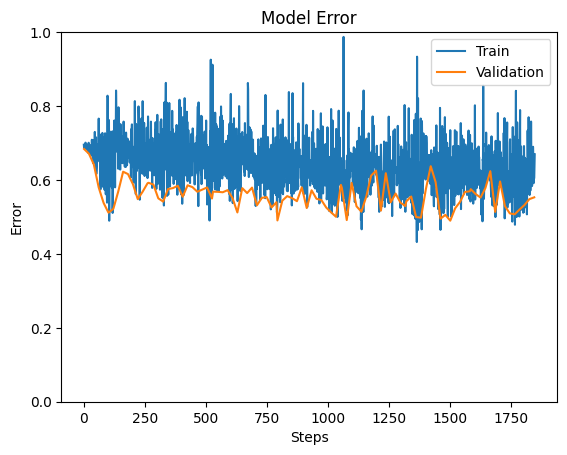

In [27]:
a, b = zip(*validations)

plt.plot(losses, label="Train")
plt.plot(a, b, label="Validation")
plt.xlabel("Steps")
plt.ylabel("Error")
plt.ylim(0, 1)
plt.title("Model Error")
plt.legend()
plt.show()

Final Accuracy: 0.7061634846031666


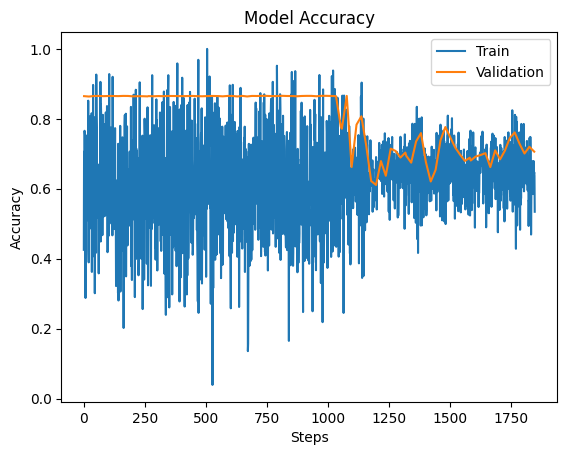

In [28]:
a, b = zip(*val_accs)
print(f"Final Accuracy: {b[-1]}")

plt.plot(accuracies, label="Train")
plt.plot(a, b, label="Validation")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

Testing

(256, 256, 3)


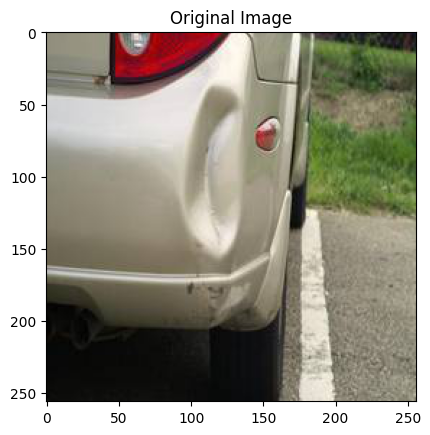

In [29]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/damage_coco/test/0/1.jpg')
plt.imshow(img)
plt.title("Original Image")
print(img.shape) 

0
0
0
15150
20445
22159
20366


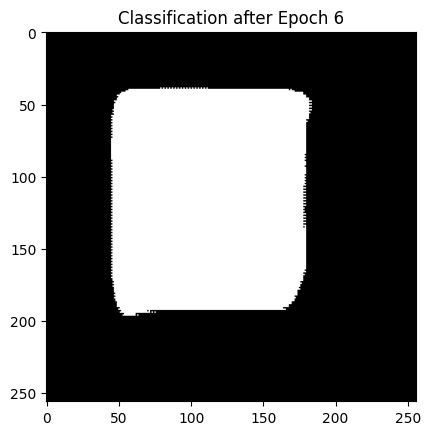

In [30]:
for i, p in enumerate(pred_img):
  q = p.squeeze(0).argmax(0).cpu().detach().numpy()
  plt.imshow(q, cmap="gray")
  plt.title(f"Classification after Epoch {i}")
  print(np.sum(q))

In [24]:
print(len(train_dataset))

1579


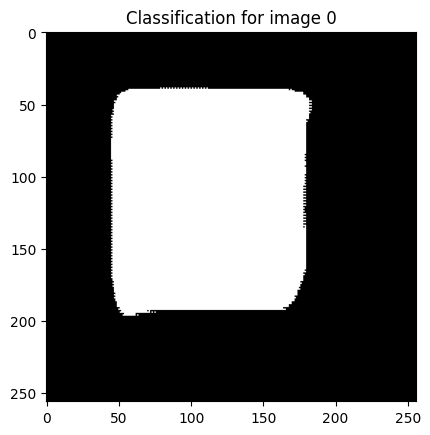

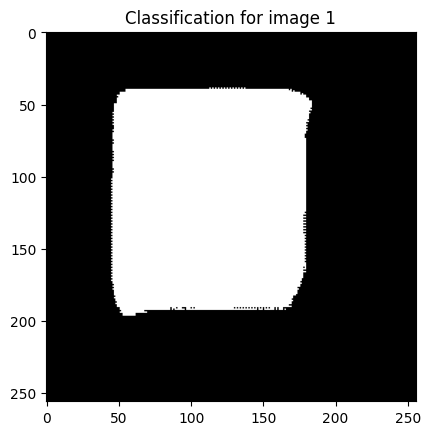

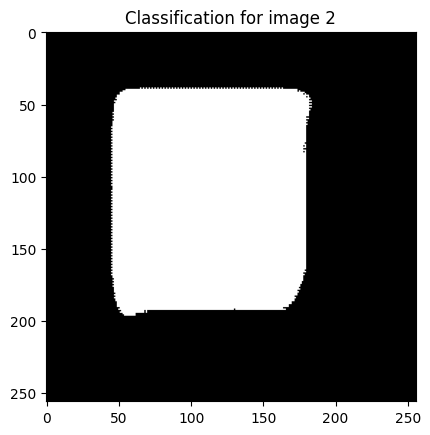

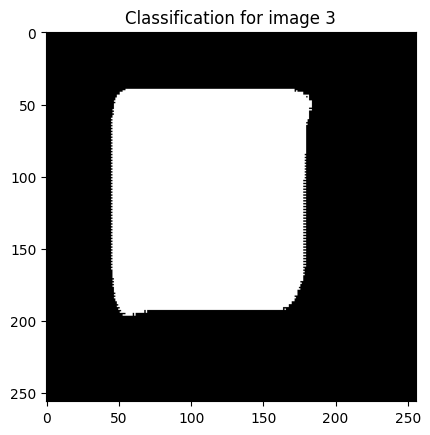

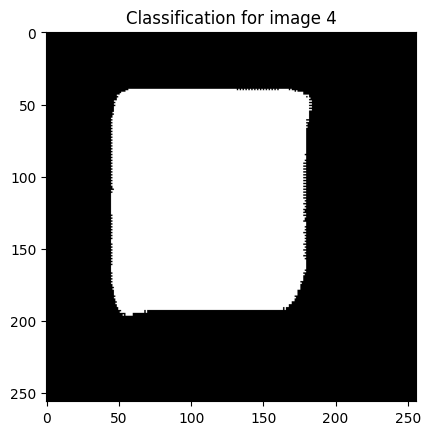

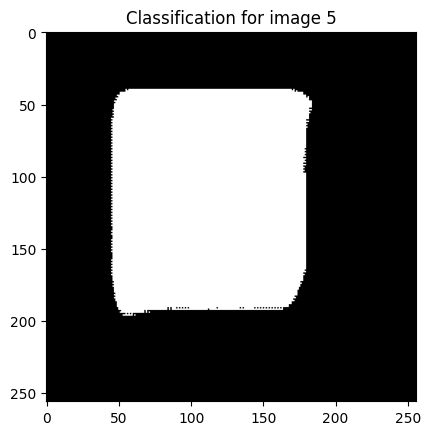

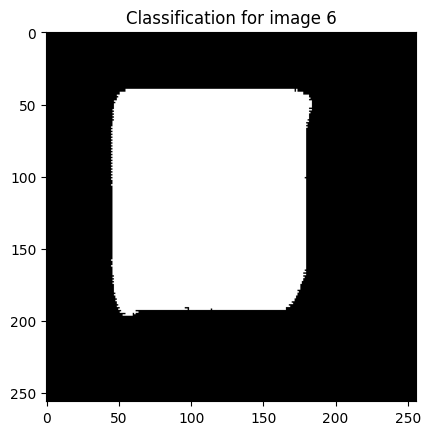

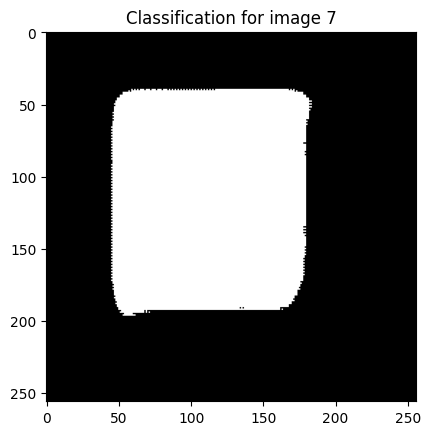

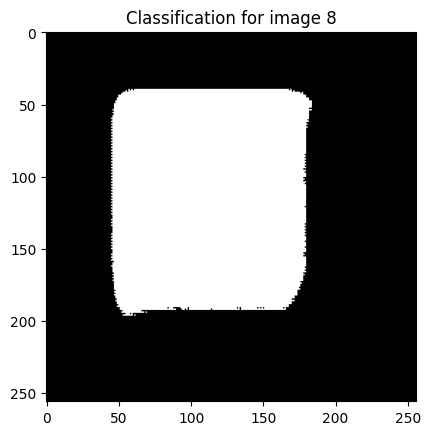

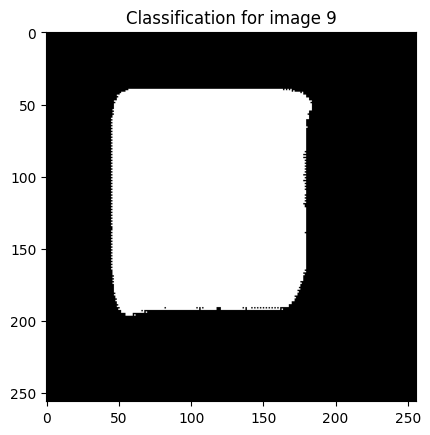

0 classifications found damage


In [32]:
# check if anything returned something nonzero
import time
count = 0
for i in range(0, 10):
  q = model(val_dataset[i][0].unsqueeze(0).cuda()).squeeze(0).argmax(0).cpu().detach().numpy()
  plt.imshow(q, cmap="gray")
  plt.title(f"Classification for image {i}")
  plt.show()
  # if np.sum(q) != 0:
  #   count += 1
  #   print(i, np.sum(q))

print(f"{count} classifications found damage")